# Import packages & functions

In [25]:
# import nbformat
# from nbconvert import PythonExporter

# def convert_ipynb_to_py(input_file, output_file):
#     # Load the notebook
#     with open(input_file, 'r', encoding='utf-8') as f:
#         nb = nbformat.read(f, as_version=4)

#     # Convert to Python
#     exporter = PythonExporter()
#     source_code, _ = exporter.from_notebook_node(nb)

#     # Write to output file
#     with open(output_file, 'w', encoding='utf-8') as f:
#         f.write(source_code)

# # Usage
# input_ipynb = 'Train.ipynb'  # Replace with your notebook path
# output_py = 'diff_prior.py'  # Replace with your desired output path

# convert_ipynb_to_py(input_ipynb, output_py)


In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import umap
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import io

import webdataset as wds
import gc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

from accelerate import Accelerator

sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
from generative_models.sgm.models.diffusion import DiffusionEngine
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1

accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
global_batch_size = batch_size = 128

LOCAL RANK  0


In [ ]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
num_workers = num_devices
print(accelerator.state)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'

# set data_type to match your mixed precision
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

# Configurations

In [4]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "testing"
    print("model_name:", model_name)
    
    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=/weka/proj-fmri/shared/mindeyev2_dataset \
                    --model_name={model_name} --use_prior --prior_scale=30 --clip_scale=1 \
                    --subj=1 --batch_size={batch_size} --no-blurry_recon --hidden_dim=1024 --num_sessions=3 --seq_len=1 \
                    --max_lr=3e-4 --mixup_pct=.66 --num_epochs=12 --no-use_image_aug --ckpt_interval=5 --no-ckpt_saving"
    
    jupyter_args = jupyter_args.split()
    print(jupyter_args)
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: testing
['--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset', '--model_name=testing', '--use_prior', '--prior_scale=30', '--clip_scale=1', '--subj=1', '--batch_size=128', '--no-blurry_recon', '--hidden_dim=1024', '--num_sessions=3', '--seq_len=1', '--max_lr=3e-4', '--mixup_pct=.66', '--num_epochs=12', '--no-use_image_aug', '--ckpt_interval=5', '--no-ckpt_saving']


In [5]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/fsx/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,5,7],
)
parser.add_argument(
    "--num_sessions", type=int, default=0,
    help="Number of training sessions to include (zero = all sessions)",
)
parser.add_argument(
    "--use_prior",action=argparse.BooleanOptionalAction,default=False,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--batch_size", type=int, default=32,
    help="Batch size can be increased by 10x if only training v2c and not diffusion diffuser",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--blur_scale",type=float,default=100.,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--prior_scale",type=float,default=1,
    help="multiply diffusion prior loss by this",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=False,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=120,
    help="number of epochs of training",
)
parser.add_argument(
    "--hidden_dim",type=int,default=2048,
)
parser.add_argument(
    "--seq_len",type=int,default=1,
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

# seed all random functions
utils.seed_everything(seed)

outdir = os.path.abspath(f'../train_logs/{model_name}')
if not os.path.exists(outdir) and ckpt_saving:
    os.makedirs(outdir,exist_ok=True)
    
if use_image_aug:
    import kornia
    from kornia.augmentation.container import AugmentationSequential
    img_augment = AugmentationSequential(
        kornia.augmentation.RandomResizedCrop((224,224), (0.6,1), p=0.3),
        kornia.augmentation.Resize((224, 224)),
        kornia.augmentation.RandomHorizontalFlip(p=0.3),
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.3),
        kornia.augmentation.RandomGrayscale(p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )

# Prep data, models, and dataloaders

## Dataloader

In [6]:
def my_split_by_node(urls): return urls

nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])

if num_sessions == 0: num_sessions = nsessions_allsubj[subj-1]

num_samples_per_epoch = 12800 // num_devices 
# or if you want less samples per epoch if you're using less data, can do (750*num_sessions) // num_devices 

num_iterations_per_epoch = num_samples_per_epoch // batch_size

print("num_sessions =", num_sessions, "batch_size =", batch_size, "num_iterations_per_epoch =",num_iterations_per_epoch, "num_samples_per_epoch =",num_samples_per_epoch,)

num_sessions = 3 batch_size = 128 num_iterations_per_epoch = 100 num_samples_per_epoch = 12800


In [7]:
train_url = f"{data_path}/wds/subj0{subj}/train/" + "{0.." + f"{num_sessions-1}" + "}.tar"
print(train_url)

train_data = wds.WebDataset(train_url,resampled=True,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])\
                    .with_epoch(num_samples_per_epoch)
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

# if using same test dataset as MindEyeV1:
test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"

## if using all shared1000 test images now that they released the last 3 sessions per participant:
# test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"

print(test_url)

num_test = 2770 # total number of test samples
test_batch_size = 300 # number of test samples to use during validation
test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=False, pin_memory=True)

/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..2}.tar
/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/test/0.tar


### check dataloaders are working

In [8]:
# test_vox_indices = []
# test_73k_images = []
# for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
#     test_vox_indices = np.append(test_vox_indices, behav[:,0,5].cpu().numpy())
#     test_73k_images = np.append(test_73k_images, behav[:,0,0].cpu().numpy())
# test_vox_indices = test_vox_indices.astype(np.int16)
# print(test_i, (test_i+1) * num_test, len(test_vox_indices))
# print("---\n")

# train_vox_indices = []
# train_73k_images = []
# for train_i, (behav, past_behav, future_behav, old_behav) in enumerate(train_dl):
#     train_vox_indices = np.append(train_vox_indices, behav[:,0,5].long().cpu().numpy())
#     train_73k_images = np.append(train_73k_images, behav[:,0,0].cpu().numpy())
# train_vox_indices = train_vox_indices.astype(np.int16)
# print(train_i, (train_i+1) * batch_size, len(train_vox_indices))

## example output ##
# 0 2770 2770
# ---
# 99 12800 12800

## Load data and images

In [9]:
# load betas (use fp32 hdf5 file to have more flexible precision and include all sessions inc. those released after algonauts)
f = h5py.File(f'{data_path}/betas_all_subj0{subj}_fp32.hdf5', 'r')

voxels = f['betas'][:]
print(f"subj0{subj} betas loaded into memory")
voxels = torch.Tensor(voxels).to("cpu").to(data_type)
print("voxels", voxels.shape)
num_voxels = voxels.shape[-1]

# load orig images
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu").to(data_type)
print("images", images.shape)

subj01 betas loaded into memory
voxels torch.Size([30000, 15724])
images torch.Size([73000, 3, 224, 224])


## Load models

### CLIP image embeddings  model

In [10]:
# from models import Clipper
# clip_model = Clipper("ViT-L/14", device=torch.device(f"cuda:{local_rank}"), hidden_state=True, norm_embs=True)
# clip_seq_dim = 257
# clip_emb_dim = 768 

clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

### SD VAE

In [11]:
if blurry_recon:
    from diffusers import AutoencoderKL
    autoenc = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=data_type, cache_dir="/weka/proj-fmri/shared/cache")
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(device)
    utils.count_params(autoenc)

#### downsampled images

In [12]:
if blurry_recon:
    if utils.is_interactive(): display(utils.torch_to_Image(images[[30]]))

    input_batch = images[[30]].to(device)
    print(input_batch.shape)

    downsampled_image = nn.functional.interpolate(input_batch, size=(8, 8), mode='bilinear', align_corners=False)
    re_upsampled_image = nn.functional.interpolate(downsampled_image, size=(128, 128), mode='nearest')
    re_upsampled_enc = autoenc.encode(2*re_upsampled_image-1).latent_dist.mode() * 0.18215
    print(re_upsampled_enc.shape)
    
    if utils.is_interactive(): display(utils.torch_to_Image((autoenc.decode(re_upsampled_enc/0.18215).sample / 2 + 0.5).clamp(0,1)))

### MindEye modules

In [13]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [14]:
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_size, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linear = torch.nn.Linear(input_size, out_features)
    def forward(self, x):
        if x.ndim == 3: # do ridge mapping the same way for each timepoint
            ridge_out = torch.cat([self.linear(x[:,xi])[:,None] for xi in range(x.shape[1])], dim=1)
            return ridge_out
        else:
            x = self.linear(x).unsqueeze(1)
            return x
        
model.ridge = RidgeRegression(voxels.shape[1], out_features=hidden_dim)
utils.count_params(model.ridge)
utils.count_params(model)

fake_input = torch.randn((2,voxels.shape[1]))
print(fake_input.shape)
print(model.ridge(fake_input).shape)

param counts:
16,102,400 total
16,102,400 trainable
param counts:
16,102,400 total
16,102,400 trainable
torch.Size([2, 15724])
torch.Size([2, 1, 1024])


In [15]:
from functools import partial
from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, out_dim=768, in_dim=15724, seq_len=2, h=4096, n_blocks=4, drop=.15, clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        
        # Mixer Blocks
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.clin1 = nn.Linear(h * seq_len, out_dim, bias=True)

        self.clip_proj = nn.Sequential(
            nn.LayerNorm(clip_size),
            nn.GELU(),
            nn.Linear(clip_size, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Linear(2048, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Linear(2048, clip_size)
        )

        if blurry_recon:
            self.blin1 = nn.Sequential(
                nn.Linear(h*seq_len, 4096, bias=True),
                nn.LayerNorm(4096),
                nn.GELU(),
                nn.Linear(4096, 4096))
            self.bgroupnorm = nn.GroupNorm(1, 256)
            self.bupsampler = Decoder(
                in_channels=256,
                out_channels=4,
                up_block_types=["UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D"],
                block_out_channels=[32, 64, 128],
                layers_per_block=1,
            )
        
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
        
    def forward(self, x, b=torch.Tensor([0.])):        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
        
        x = x.reshape(x.size(0), -1)
        backbone = self.clin1(x).reshape(len(x), -1, self.clip_size)
        c = self.clip_proj(backbone)

        if blurry_recon:
            b = self.blin1(x)
            b = b.reshape(len(b), 256, 4, 4)
            b = self.bgroupnorm(b)
            b = self.bupsampler(b)
        
        return backbone, c, b

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=seq_len, clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim) 
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
fake_input = torch.randn((2,seq_len,hidden_dim))
print("fake_input.shape", fake_input.shape)
backbone_, clip_, blur_ = model.backbone(fake_input)
print(backbone_.shape, clip_.shape, blur_.shape)

param counts:
456,065,944 total
456,065,944 trainable
param counts:
472,168,344 total
472,168,344 trainable
fake_input.shape torch.Size([2, 1, 1024])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([1])


### Adding diffusion prior + unCLIP if use_prior=True

In [16]:
if use_prior:
    from models import *

    # setup diffusion prior network
    out_dim = clip_emb_dim
    depth = 3 #6
    dim_head = 208 # 64
    heads = clip_emb_dim//208 # heads * dim_head = clip_emb_dim
    guidance_scale = 3.5
    timesteps = 100

    prior_network = VersatileDiffusionPriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = clip_seq_dim,
            learned_query_mode="pos_emb"
        )

    model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
        voxel2clip=None,
    )
    
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)
    
    # prep unCLIP
    config = OmegaConf.load("generative_models/configs/unclip6.yaml")
    config = OmegaConf.to_container(config, resolve=True)
    unclip_params = config["model"]["params"]
    network_config = unclip_params["network_config"]
    denoiser_config = unclip_params["denoiser_config"]
    first_stage_config = unclip_params["first_stage_config"]
    conditioner_config = unclip_params["conditioner_config"]
    sampler_config = unclip_params["sampler_config"]
    scale_factor = unclip_params["scale_factor"]
    disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
    offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

    first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
    sampler_config['params']['num_steps'] = 38

    diffusion_engine = DiffusionEngine(network_config=network_config,
                           denoiser_config=denoiser_config,
                           first_stage_config=first_stage_config,
                           conditioner_config=conditioner_config,
                           sampler_config=sampler_config,
                           scale_factor=scale_factor,
                           disable_first_stage_autocast=disable_first_stage_autocast)
    # set to inference
    diffusion_engine.eval().requires_grad_(False)
    diffusion_engine.to(device)

    ckpt_path = '/weka/proj-fmri/shared/cache/sdxl_unclip/unclip6_epoch0_step110000.ckpt'
    ckpt = torch.load(ckpt_path, map_location='cpu')
    diffusion_engine.load_state_dict(ckpt['state_dict'])
    
    image = images[:1].to(device)
    batch={"jpg": image,
          "original_size_as_tuple": torch.ones(image.shape[0], 2).to(device) * image.shape[-1],
          "crop_coords_top_left": torch.zeros(image.shape[0], 2).to(device)}
    out = diffusion_engine.conditioner(batch)
    vector_suffix = out["vector"].to(device)
    print("vector_suffix", vector_suffix.shape)

param counts:
144,594,800 total
144,594,784 trainable
param counts:
616,763,144 total
616,763,128 trainable


Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
vector_suffix torch.Size([1, 1024])


### Setup optimizer / lr / ckpt saving

In [17]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

if use_prior:
    opt_grouped_parameters = [
        {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]
else:
    opt_grouped_parameters = [
        {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*num_iterations_per_epoch)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(np.floor(num_epochs*num_iterations_per_epoch))
    print("total_steps", total_steps)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):    
    ckpt_path = outdir+f'/{tag}.pth'
    print(f'saving {ckpt_path}',flush=True)
    unwrapped_model = accelerator.unwrap_model(model)
    try:
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    except:
        print("Couldn't save... moving on to prevent crashing.")
    del unwrapped_model

utils.count_params(model)
print("\nDone with model preparations!")

total_steps 1200
param counts:
616,763,144 total
616,763,128 trainable

Done with model preparations!


## Weights and Biases

In [18]:
wandb_log = True

In [19]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'MEV2'
    print(f"wandb {wandb_project} run unCLIP")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": "unCLIP",
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      # "num_params": num_params,
      "clip_scale": clip_scale,
      "blur_scale": blur_scale,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "mixup_pct": mixup_pct,
      "num_samples_per_epoch": num_samples_per_epoch,
      "num_test": num_test,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_url": train_url,
      "test_url": test_url,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id: unCLIP")
    wandb.init(
        project=wandb_project,
        name="unCLIP",
        config=wandb_config,
        resume="allow",
    )
else:
    wandb_log = False

wandb MEV2 run unCLIP
wandb_config:
 {'model_name': 'unCLIP', 'global_batch_size': 128, 'batch_size': 128, 'num_epochs': 12, 'clip_scale': 1.0, 'blur_scale': 100.0, 'use_image_aug': False, 'max_lr': 0.0003, 'mixup_pct': 0.66, 'num_samples_per_epoch': 12800, 'num_test': 2770, 'ckpt_interval': 5, 'ckpt_saving': False, 'seed': 42, 'distributed': False, 'num_devices': 1, 'world_size': 1, 'train_url': '/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..2}.tar', 'test_url': '/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/test/0.tar'}
wandb_id: unCLIP


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mihirneal. Use `wandb login --relogin` to force relogin


# Main

In [20]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))

# Optionally resume from checkpoint #
# if resume_from_ckpt:
#     print("\n---resuming from last.pth ckpt---\n")
#     checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
#     epoch = checkpoint['epoch']
#     print("Epoch",epoch)
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
#     model.load_state_dict(checkpoint['model_state_dict'])
#     del checkpoint
# elif wandb_log:
#     if wandb.run.resumed:
#         print("\n---resuming from last.pth ckpt---\n")
#         checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
#         epoch = checkpoint['epoch']
#         print("Epoch",epoch)
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
#         model.load_state_dict(checkpoint['model_state_dict'])
#         del checkpoint
# torch.cuda.empty_cache()

In [21]:
model, optimizer, train_dl, lr_scheduler = accelerator.prepare(
model, optimizer, train_dl, lr_scheduler
)
# leaving out test_dl since we will only have local_rank 0 device do evals

In [22]:
blurry_recon

False

In [23]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()

for epoch in progress_bar:
    model.train()
    
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.
    
    recon_cossim = 0.
    test_recon_cossim = 0.
    recon_mse = 0.
    test_recon_mse = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    test_loss_clip_total = 0.
    test_loss_blurry_total = 0.
    
    loss_prior_total = 0.
    test_loss_prior_total = 0.

    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. # needs >.456 to beat low-level subj01 results in mindeye v1
    
    for train_i, (behav, past_behav, future_behav, old_behav) in enumerate(train_dl):
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()
            loss=0.
    
            voxel = voxels[behav[:,0,5].cpu().long()].to(device)
            image = images[behav[:,0,0].cpu().long()].to(device).float()

            if seq_len > 1:
                past_behavior = past_behav[:,:(seq_len-1),5].cpu().long()
                past_voxel = voxels[past_behavior]
                if torch.any(past_behavior==-1).item(): # remove invalid voxels (-1 if there is no timepoint available)
                    past_voxel[torch.where(past_behavior==-1)[0]] = 0
                past_voxel = torch.Tensor(past_voxel).to(data_type).to(device)
    
            if blurry_recon:
                # using pixellated blurry ground truth references seems to do better than gaussian blur
                rand = np.random.rand() 
                if rand > .66: # using different interpolation sizes for data augmentation
                    blurry_image = utils.resize(nn.functional.interpolate(image, size=(8, 8), mode='bilinear', align_corners=False),128)
                elif rand > .33:
                    blurry_image = utils.resize(nn.functional.interpolate(image, size=(12, 12), mode='bilinear', align_corners=False),128)
                else:
                    blurry_image = utils.resize(nn.functional.interpolate(image, size=(24, 24), mode='bilinear', align_corners=False), 128)
                # blurry_image = utils.add_saturation(blurry_image) # PS: I'm not sure that this helps
                blurry_image_enc = autoenc.encode(2*blurry_image-1).latent_dist.mode() * 0.18215
            
            if use_image_aug: 
                image = img_augment(image)
    
            clip_target = clip_img_embedder(image)
            assert not torch.any(torch.isnan(clip_target))
    
            if epoch < int(mixup_pct * num_epochs):
                voxel, perm, betas, select = utils.mixco(voxel)
    
            voxel_ridge = model.ridge(voxel)

            if seq_len > 1:
                past_voxel_ridge = model.ridge(past_voxel)
                voxel_ridge = torch.cat((voxel_ridge, past_voxel_ridge), axis=1)
    
            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)
            backbone = backbone + .1598 # using mean of clip_target
            
            clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
            clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
            
            if use_prior:
                    loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                    loss_prior *= prior_scale
                    loss += loss_prior
                    loss_prior_total += loss_prior.item()
                    
                    recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                    recon_mse += mse(prior_out,clip_target).item()
    
            if clip_scale>0:
                if epoch < int(mixup_pct * num_epochs):                
                    loss_clip = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006, 
                        perm=perm, betas=betas, select=select)
                else:
                    epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp)

                loss_clip_total += loss_clip.item()
                loss_clip *= clip_scale
                loss += loss_clip
    
            if blurry_recon:
                loss_blurry = l1(blurry_image_enc_, blurry_image_enc)
                loss_blurry_total += loss_blurry.item()
                loss_blurry *= blur_scale
                loss += loss_blurry
    
            # forward and backward top 1 accuracy        
            labels = torch.arange(len(clip_target_norm)).to(clip_voxels_norm.device) 
            fwd_percent_correct += utils.topk(torch.abs(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm)), labels, k=1).item()
            bwd_percent_correct += utils.topk(torch.abs(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm)), labels, k=1).item()
    
            if blurry_recon:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(voxel)), size=batch_size//5, replace=False)
                    blurry_recon_images = (autoenc.decode(blurry_image_enc_[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    blurry_pixcorr += pixcorr.item()

            utils.check_loss(loss)
            accelerator.backward(loss)
            optimizer.step()
    
            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])
    
            if lr_scheduler_type is not None:
                lr_scheduler.step()

    model.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):  
                # all test samples should be loaded per batch such that test_i should never exceed 0
                assert len(behav) == num_test
                
                ## Average same-image repeats ##
                if test_image is None:
                    voxel = voxels[behav[:,0,5].cpu().long()]

                    if seq_len > 1:
                        past_behavior = past_behav[:,:(seq_len-1),5].cpu().long()
                        past_voxel = voxels[past_behavior]
                        if torch.any(past_behavior==-1).item(): # remove invalid voxels (-1 if there is no timepoint available)
                            past_voxel[torch.where(past_behavior==-1)[0]] = 0
                        past_voxel = torch.Tensor(past_voxel).to(data_type)
                
                    image = behav[:,0,0].cpu().long()
                
                    unique_image, sort_indices = torch.unique(image, return_inverse=True)
                    for im in unique_image:
                        locs = torch.where(im == image)[0]
                        if len(locs)==1:
                            locs = locs.repeat(3)
                        elif len(locs)==2:
                            locs = locs.repeat(2)[:3]
                        assert len(locs)==3
                        if test_image is None:
                            test_image = images[im][None]
                            test_voxel = voxel[locs][None]
                            if seq_len > 1:
                                test_past_voxel = past_voxel[locs][None]
                        else:
                            test_image = torch.vstack((test_image, images[im][None]))
                            test_voxel = torch.vstack((test_voxel, voxel[locs][None]))
                            if seq_len > 1:
                                test_past_voxel = torch.vstack((test_past_voxel, past_voxel[locs][None]))
    
                loss=0.
                
                # validation sample of 300
                val_indices = torch.arange(len(test_voxel))[:test_batch_size]
                voxel = test_voxel[val_indices].to(device)
                if seq_len > 1: past_voxel = test_past_voxel[val_indices].to(device)
                image = test_image[val_indices].to(device)
                assert len(image) == 300
                
                for rep in range(3):
                    voxel_ridge = model.ridge(voxel[:,rep])
                    if seq_len > 1:
                        past_voxel_ridge = model.ridge(past_voxel[:,rep])
                        voxel_ridge = torch.cat((voxel_ridge, past_voxel_ridge), axis=1)
                    backbone0, clip_voxels0, blurry_image_enc_0 = model.backbone(voxel_ridge)
                    if rep==0:
                        clip_voxels = clip_voxels0
                        backbone = backbone0
                        if blurry_recon: blurry_image_enc_ = blurry_image_enc_0
                    else:
                        clip_voxels += clip_voxels0
                        backbone += backbone0
                        if blurry_recon: blurry_image_enc_ += blurry_image_enc_0
                clip_voxels /= 3
                backbone /= 3
                backbone = backbone + .1598 # using mean of clip_target
                if blurry_recon: 
                    blurry_image_enc_ /= 3
                    blurry_image_enc = autoenc.encode(2*utils.resize(image,128)-1).latent_dist.mode() * 0.18215
            
                clip_target = clip_img_embedder(image.float())
                
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
                
                if use_prior:
                    loss_prior, _ = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                    loss_prior *= prior_scale
                    loss += loss_prior
                    test_loss_prior_total += loss_prior.item()
                    
                    # now get unCLIP prediction without feeding it the image embed to get uncontaminated reconstruction
                    prior_out = model.diffusion_prior.p_sample_loop(backbone.shape, 
                                    text_cond = dict(text_embed = backbone), 
                                    cond_scale = 1., timesteps = timesteps)
                    
                    test_recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                    test_recon_mse += mse(prior_out,clip_target).item()
        
                if clip_scale>0:
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006)
                    test_loss_clip_total += loss_clip.item()
                    loss_clip = loss_clip * clip_scale
                    loss += loss_clip

                if blurry_recon:
                    loss_blurry = l1(blurry_image_enc_, blurry_image_enc)
                    test_loss_blurry_total += loss_blurry.item()
                    loss_blurry *= blur_scale
                    loss += loss_blurry
    
                    # halving the batch size because the decoder is computationally heavy
                    blurry_recon_images = (autoenc.decode(blurry_image_enc_[:len(voxel)//2]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    blurry_recon_images = torch.vstack((blurry_recon_images, (autoenc.decode(blurry_image_enc_[len(voxel)//2:]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    pixcorr = utils.pixcorr(image, blurry_recon_images)
                    test_blurry_pixcorr += pixcorr.item()
        
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_target_norm)).to(clip_voxels_norm.device) 
                test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

                utils.check_loss(loss)                
                test_losses.append(loss.item())

            print("---")
            
            assert (test_i+1) == 1
            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
                "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                "test/loss_blurry_total": test_loss_blurry_total / (test_i + 1),
                "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
                "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
                "train/recon_cossim": recon_cossim / (train_i + 1),
                "test/recon_cossim": test_recon_cossim / (test_i + 1),
                "train/recon_mse": recon_mse / (train_i + 1),
                "test/recon_mse": test_recon_mse / (test_i + 1),
                "train/loss_prior": loss_prior_total / (train_i + 1),
                "test/loss_prior": test_loss_prior_total / (test_i + 1),
                }
    
            if blurry_recon:    
                # transform blurry recon latents to images and plot it
                fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                jj=-1
                for j in [0,1,2,3]:
                    jj+=1
                    axes[jj].imshow(utils.torch_to_Image((autoenc.decode(blurry_image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].axis('off')
                    jj+=1
                    axes[jj].imshow(utils.torch_to_Image((autoenc.decode(blurry_image_enc_[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].axis('off')
                
                if wandb_log:
                    logs[f"test/recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                    plt.close()
                else:
                    plt.show()
                    
            if use_prior: # output recons every ckpt
                if (epoch == num_epochs-1) or (epoch % ckpt_interval == 0):
                    print("Embedding UMAP")
                    
                    backbone_flat = backbone.reshape(backbone.shape[0], -1)
                    clip_target_flat = clip_target.reshape(clip_target.shape[0], -1)
                    combined_embeddings = np.vstack([backbone_flat, clip_target_flat])
                    umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='euclidean')
                    umap_projections = umap_model.fit_transform(combined_embeddings)
                    backbone_proj, clip_target_proj = np.split(umap_projections, 2)
                    euclidean_dist = euclidean(backbone_flat.mean(axis=0), clip_target_flat.mean(axis=0))

                    # Plotting
                    plt.scatter(backbone_proj[:, 0], backbone_proj[:, 1], label='Backbone', alpha=0.7)
                    plt.scatter(clip_target_proj[:, 0], clip_target_proj[:, 1], label='Clip Target', alpha=0.7)
                    plt.title(f'UMAP Projection (Euclidean Distance: {euclidean_dist:.2f})')
                    plt.legend()

                    buf = io.BytesIO()
                    plt.savefig(buf, format='png')
                    buf.seek(0)
                    wandb.log({"UMAP Projection, iteration {test_i}": wandb.Image(buf)})
                    plt.close()
                    
                    
                    print("reconstructing...")
                    samples = utils.unclip_recon(prior_out,
                                                 diffusion_engine,
                                                 vector_suffix)
                    if wandb_log:
                        if epoch==0:
                            logs[f"test/orig"] = wandb.Image(transforms.ToPILImage()(image[0]),
                                                           caption=f"epoch{epoch:03d}")
                        logs[f"test/recons"] = wandb.Image(transforms.ToPILImage()(samples[0]),
                                                           caption=f"epoch{epoch:03d}")
                    if utils.is_interactive():
                        if epoch==0:
                            plt.figure(figsize=(2,2))
                            plt.imshow(transforms.ToPILImage()(image[0]))
                            plt.axis('off')
                            plt.show()
                            
                        plt.figure(figsize=(2,2))
                        plt.imshow(transforms.ToPILImage()(samples[0]))
                        plt.axis('off')
                        plt.show()
            
            progress_bar.set_postfix(**logs)
    
            # Save model checkpoint and reconstruct
            if epoch % ckpt_interval == 0 and ckpt_saving:
                if not utils.is_interactive():
                    save_ckpt(f'last')
                    
            if wandb_log: wandb.log(logs)

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    gc.collect()

print("\n===Finished!===\n")
if ckpt_saving:
    save_ckpt(f'last')
if not utils.is_interactive():
    sys.exit(0)

testing starting with epoch 0 / 12


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

OutOfMemoryError: CUDA out of memory. Tried to allocate 418.00 MiB. GPU 0 has a total capacty of 39.56 GiB of which 320.56 MiB is free. Including non-PyTorch memory, this process has 39.25 GiB memory in use. Of the allocated memory 37.00 GiB is allocated by PyTorch, and 678.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

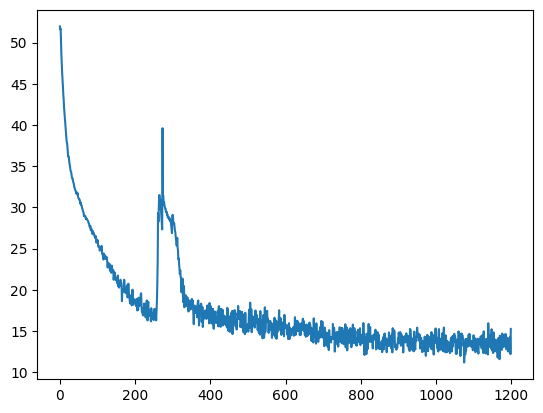

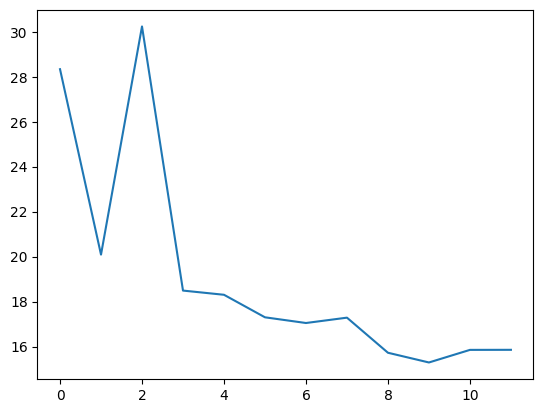

In [23]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()

# Testing the unCLIP

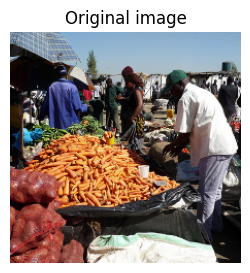

In [24]:
# image = images[[0]].to(device)
plt.figure(figsize=(3,3))
plt.imshow(transforms.ToPILImage()(image[0]))
plt.axis('off')
plt.title("Original image")
plt.show()

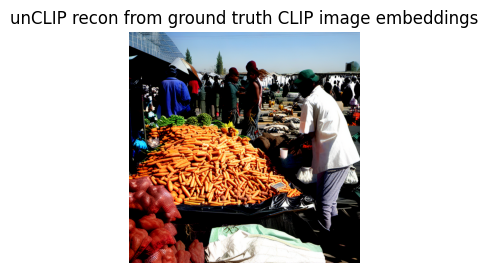

In [26]:
samples = utils.unclip_recon(clip_img_embedder(image)[[0]],
                             diffusion_engine,
                             vector_suffix)
plt.figure(figsize=(3,3))
plt.imshow(transforms.ToPILImage()(samples[0]))
plt.axis('off')
plt.title("unCLIP recon from ground truth CLIP image embeddings")
plt.show()

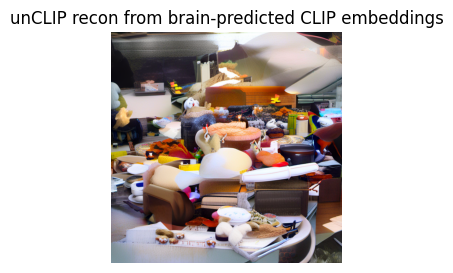

In [27]:
recon = utils.unclip_recon(prior_out[[0]],
                             diffusion_engine,
                             vector_suffix)
plt.figure(figsize=(3,3))
plt.imshow(transforms.ToPILImage()(recon[0]))
plt.axis('off')
plt.title("unCLIP recon from brain-predicted CLIP embeddings")
plt.show()